# 径向网格系统

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/01-grid.ipynb)

## 学习目标

- 理解径向坐标在球对称问题中的核心地位
- 掌握线性网格与对数网格的生成方法
- 理解网格密度分布对计算精度的影响

## 核心概念

原子薛定谔方程在球对称势下可分离变量，径向部分控制主要物理行为。连续的径向坐标 r ∈ [0, ∞) 需离散化为有限网格点，才能用数值方法求解。

## 理论基础：梯形积分与权重

对于非均匀网格 $r_0, r_1, \ldots, r_{N-1}$，梯形积分规则：

$$\int_{r_0}^{r_{N-1}} f(r)dr \approx \sum_{i=0}^{N-1} w_i f(r_i)$$

权重计算公式：

$$w_0 = \frac{r_1-r_0}{2}, \quad w_i = \frac{r_{i+1}-r_{i-1}}{2}, \quad w_{N-1} = \frac{r_{N-1}-r_{N-2}}{2}$$

**验证方法**：$\sum_i w_i \approx r_{N-1} - r_0$

**代码实现**：`trapezoid_weights(r)` 函数返回积分权重数组


In [1]:
# Colab 环境检测
import sys
if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear, radial_grid_log, trapezoid_weights

# 设置绘图风格
plt.rcParams['figure.figsize'] = (10, 6)

## 线性网格

均匀采样：r[i] = rmin + i·Δr，适合氢原子等简单体系的快速基准测试。

In [4]:
# 生成线性网格（返回两个值：r 和 w）
r_lin, w_lin = radial_grid_linear(n=500, rmin=1e-5, rmax=20.0)

# 计算局部步长
dr_lin = np.diff(r_lin)

print("线性网格信息:")
print(f"  点数: {len(r_lin)}")
print(f"  范围: [{r_lin[0]:.2e}, {r_lin[-1]:.2f}] Bohr")
print(f"  步长: {dr_lin[250]:.6f} Bohr (中心点)")

print("\n前 10 个网格点 (Bohr):")
for i in range(10):
    print(f"  r[{i}] = {r_lin[i]:.6f}")

print("\n后 10 个网格点 (Bohr):")
for i in range(-10, 0):
    print(f"  r[{500+i}] = {r_lin[i]:.6f}")

## 对数网格

在对数坐标 x = ln(r) 上均匀采样，原子核附近密集。适合多电子原子的近核高梯度区域。

In [5]:
# 生成对数网格
r_log, w_log = radial_grid_log(n=500, rmin=1e-6, rmax=20.0)

# 计算局部步长
dr_log = np.diff(r_log)

print("对数网格信息:")
print(f"  点数: {len(r_log)}")
print(f"  范围: [{r_log[0]:.2e}, {r_log[-1]:.2f}] Bohr")

# 找最接近 r=0.01 和 r=10.0 的点
idx_001 = np.argmin(np.abs(r_log - 0.01))
idx_10 = np.argmin(np.abs(r_log - 10.0))

print(f"  步长 (r≈0.01): {dr_log[idx_001]:.6e} Bohr")
print(f"  步长 (r≈10.0): {dr_log[idx_10]:.6f} Bohr")

print("\n前 10 个网格点 (Bohr):")
for i in range(10):
    print(f"  r[{i}] = {r_log[i]:.6e}")

## 网格密度可视化

对比线性与对数网格的点分布和局部步长 dr(r)：

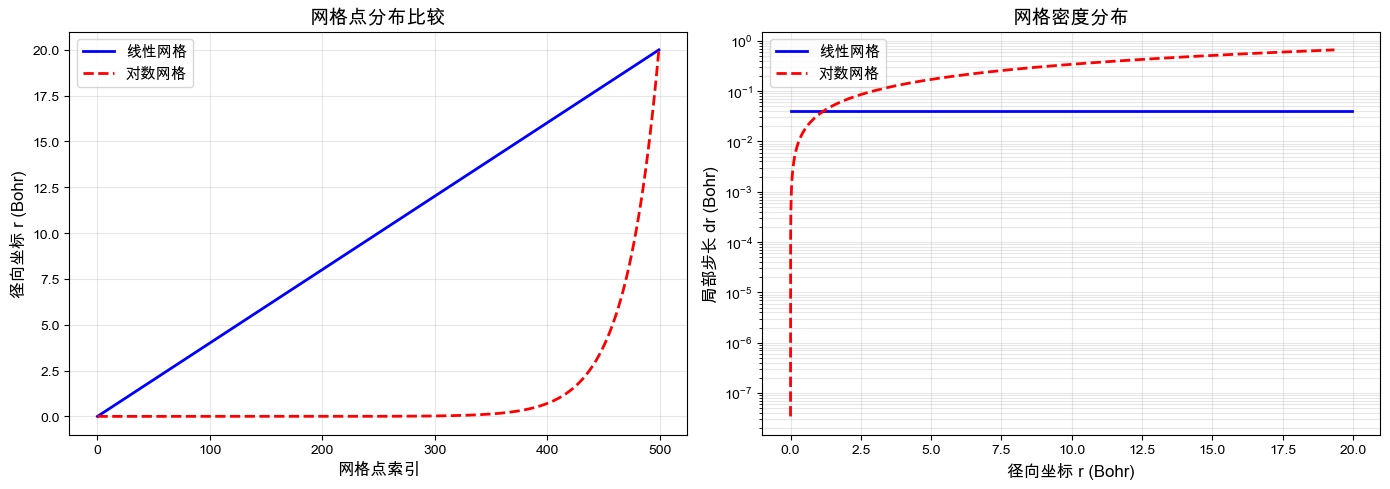

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：r 分布
ax1.plot(np.arange(len(r_lin)), r_lin, 'b-', label='线性网格', linewidth=2)
ax1.plot(np.arange(len(r_log)), r_log, 'r--', label='对数网格', linewidth=2)
ax1.set_xlabel('网格点索引', fontsize=12)
ax1.set_ylabel('径向坐标 r (Bohr)', fontsize=12)
ax1.set_title('网格点分布比较', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# 右图：dr 分布（对数刻度）
ax2.semilogy(r_lin[:-1], dr_lin, 'b-', label='线性网格', linewidth=2)
ax2.semilogy(r_log[:-1], dr_log, 'r--', label='对数网格', linewidth=2)
ax2.set_xlabel('径向坐标 r (Bohr)', fontsize=12)
ax2.set_ylabel('局部步长 dr (Bohr)', fontsize=12)
ax2.set_title('网格密度分布', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("关键观察:")
print("  • 线性网格: dr 恒定，远区浪费点")
print("  • 对数网格: dr ∝ r，近核密集，远区稀疏")
print("  • 核附近波函数变化剧烈，需要高分辨率")

## 积分权重

梯形积分权重 w[i] 用于计算波函数归一化和期望值积分：

$$\int_0^\infty f(r) dr \approx \sum_i f(r_i) w_i$$

In [7]:
# 验证积分权重：计算 ∫₀²⁰ r² dr = 20³/3
integrand_lin = r_lin**2
integrand_log = r_log**2

integral_lin = np.sum(integrand_lin * w_lin)
integral_log = np.sum(integrand_log * w_log)
exact = 20.0**3 / 3

print("积分测试: ∫₀²⁰ r² dr")
print(f"  线性网格: {integral_lin:.6f}")
print(f"  对数网格: {integral_log:.6f}")
print(f"  精确值:   {exact:.6f}")
print(f"  线性误差: {abs(integral_lin - exact)/exact * 100:.4f}%")
print(f"  对数误差: {abs(integral_log - exact)/exact * 100:.4f}%")

## 网格选择建议

| 网格类型 | 适用场景 | 典型点数 |
|---------|---------|----------|
| 线性 | 氢原子、基准测试 | 500-1000 |
| 对数 | 多电子原子、高精度 | 1000-2000 |

**关键参数**：
- `rmin`：避免奇点，通常 10⁻⁵ ~ 10⁻⁶ Bohr
- `rmax`：覆盖波函数衰减区，通常 20-50 Bohr
- `n`：精度与效率平衡，500 点足够教学

## 下一步

在 **[02-solver.ipynb](02-solver.ipynb)** 中，将使用这些网格求解径向薛定谔方程。